# Generate CO2 effect scalar map for hybrid modeling

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from dask.distributed import Client, LocalCluster
import glob
import time
from pandas.tseries.offsets import MonthEnd

import dask
dask.config.set({'temporary_directory': '/global/scratch/users/yanghuikang/upscale/data/temp'})

import sys
sys.path.insert(0, '../utility')
import model_config as mcf
# import preprocess as pr
import cfe as cfe

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
cluster = LocalCluster(ip='*') 
client = Client(cluster)
client

distributed.diskutils - INFO - Found stale lock file and directory '/global/scratch/users/yanghuikang/upscale/data/temp/dask-worker-space/worker-zu1bk4fq', purging
distributed.diskutils - INFO - Found stale lock file and directory '/global/scratch/users/yanghuikang/upscale/data/temp/dask-worker-space/worker-402rtruu', purging
distributed.diskutils - INFO - Found stale lock file and directory '/global/scratch/users/yanghuikang/upscale/data/temp/dask-worker-space/worker-58hod8uc', purging
distributed.diskutils - INFO - Found stale lock file and directory '/global/scratch/users/yanghuikang/upscale/data/temp/dask-worker-space/worker-3thb2h_a', purging
distributed.diskutils - INFO - Found stale lock file and directory '/global/scratch/users/yanghuikang/upscale/data/temp/dask-worker-space/worker-b9n77q6v', purging
distributed.diskutils - INFO - Found stale lock file and directory '/global/scratch/users/yanghuikang/upscale/data/temp/dask-worker-space/worker-8ra7u38i', purging
distributed.disk

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://10.0.7.164:8787/status,
Dashboard: http://10.0.7.164:8787/status,Workers: 8
Total threads: 40,Total memory: 351.56 GiB
Status: running,Using processes: True
Comm: tcp://10.0.7.164:38468,Workers: 8
Dashboard: http://10.0.7.164:8787/status,Total threads: 40
Started: Just now,Total memory: 351.56 GiB
Comm: tcp://10.0.7.164:43992,Total threads: 5
Dashboard: http://10.0.7.164:37715/status,Memory: 43.95 GiB
Nanny: tcp://10.0.7.164:41564,


In [4]:
# Settings
dataset_name = 'ERA5'
var_name = 'p1'

zarr_path = '/global/scratch/users/yanghuikang/upscale/data/processed/monthly/' 

In [5]:
# Read CO2 data
co2 = pd.read_csv('/global/scratch/users/yanghuikang/upscale/data/site/co2_mlo_spo_filled.csv',index_col=False)
co2 = co2.rename(columns={'average':'CO2'})
co2['year'] = co2['year'].astype(int)
co2['month'] = co2['month'].astype(int)
co2['day'] = 1
co2['time'] = pd.to_datetime(co2[['year','month','day']]) + MonthEnd()
co2_ar = co2[['time','CO2']].set_index('time')

co2_ds = xr.Dataset.from_dataframe(co2_ar)

co2_ds

<xarray.Dataset>
Dimensions:  (time: 492)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-31 1980-02-29 ... 2020-12-31
Data variables:
    CO2      (time) float64 337.0 337.2 338.1 338.6 ... 411.3 411.3 412.2 412.8

In [6]:
def preprocess_tmean(ds):
    """
    Preprocess era5 dataset, select only air temperature
    """
    ds_new = ds['temperature_2m'].drop_vars(['spatial_ref']).rename('Tmean').to_dataset()
    ds_new['Tmean'] = ds_new['Tmean'] - 273.15
    return ds_new

### Compute the CO2 variable sclar using 2001 as the base year

In [7]:
%%time
for year in range(1982,1983):
    
    print(year)

    # read era5 data
    zarr_file = zarr_path+dataset_name+'/zarr_yearly/'+var_name + '/' + str(year)
    ds = xr.open_zarr(zarr_file,consolidated=False,chunks={'x':7200,'y':3600})
    ds = preprocess_tmean(ds)

    # compute co2 effect
    co2_effect = cfe.getCO2effect_simple(ds['Tmean'], co2_ds['CO2'])
    co2_effect = co2_effect.to_dataset(name='co2scalar')

    # save
    out_name = zarr_path + 'CFE' + '/zarr_yearly/'+ 'co2scalar' + '/' + str(year)
    co2_effect.to_zarr(out_name, consolidated=True)

1982
CPU times: user 1.2 s, sys: 1.31 s, total: 2.51 s
Wall time: 22.2 s


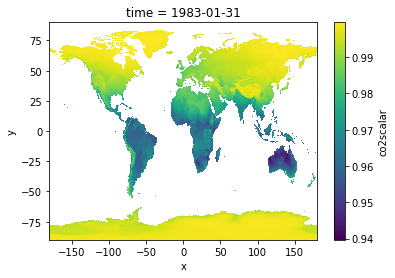

In [11]:
out_name = zarr_path + 'CFE' + '/zarr_yearly/'+ 'co2scalar' + '/' + str(1983)

test = xr.open_zarr(out_name, consolidated=False)
test['co2scalar'].isel(time=0).plot(x='x',y='y')

In [7]:
test = xr.open_zarr(zarr_path + 'CFE' + '/zarr_yearly/'+ 'co2scalar' + '/2001',consolidated=False)
test

<xarray.Dataset>
Dimensions:    (time: 12, y: 3600, x: 7200)
Coordinates:
  * time       (time) datetime64[ns] 2001-01-31 2001-02-28 ... 2001-12-31
  * x          (x) float64 -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0
  * y          (y) float64 89.97 89.92 89.88 89.82 ... -89.88 -89.93 -89.98
Data variables:
    co2scalar  (time, y, x) float64 dask.array<chunksize=(1, 3600, 7200), meta=np.ndarray>

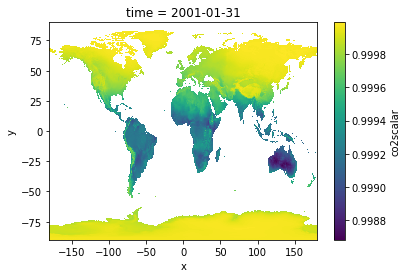

In [8]:
test.sel(time=slice('2001-01-01','2001-02-01'))['co2scalar'].plot(x='x',y='y')

### Compute the reference CO2 scalar for 1982, using 2001 as the base

In [7]:
co2_ds

<xarray.Dataset>
Dimensions:  (time: 492)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-31 1980-02-29 ... 2020-12-31
Data variables:
    CO2      (time) float64 337.0 337.2 338.1 338.6 ... 411.3 411.3 412.2 412.8

In [11]:
co2_ds_1982 = co2_ds.copy()
co2_ds_1982['CO2'].values[:] = co2[(co2['year']==1982)&(co2['month']==1)]['CO2'].iloc[0]
co2_ds_1982

<xarray.Dataset>
Dimensions:  (time: 492)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-31 1980-02-29 ... 2020-12-31
Data variables:
    CO2      (time) float64 340.3 340.3 340.3 340.3 ... 340.3 340.3 340.3 340.3

In [22]:
%%time
for year in range(2011,2020):
    
    print(year)

    # read era5 data
    zarr_file = zarr_path+dataset_name+'/zarr_yearly/'+var_name + '/' + str(year)
    ds = xr.open_zarr(zarr_file,consolidated=False,chunks={'x':7200,'y':3600})
    ds = preprocess_tmean(ds)

    # compute co2 effect
    co2_effect_1982 = cfe.getCO2effect_simple(ds['Tmean'], co2_ds_1982['CO2'])
    co2_effect_1982 = co2_effect_1982.to_dataset(name='co2scalar')

    # save
    out_name = zarr_path + 'CFE' + '/zarr_yearly/'+ 'co2scalar_1982' + '/' + str(year)
    co2_effect_1982.to_zarr(out_name, consolidated=True)

2011
2012
2013
2014
2015
2016
2017
2018
2019
CPU times: user 3.22 s, sys: 1.29 s, total: 4.51 s
Wall time: 16.2 s


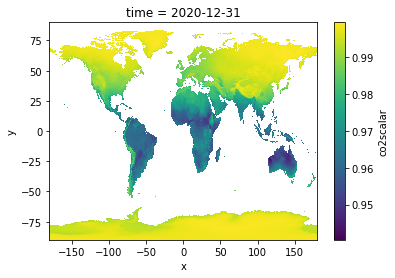

In [20]:
co2_effect_1982['co2scalar'].isel(time=11).plot(x='x',y='y')